In [1]:
from utils import *

%load_ext autoreload
%autoreload 2

In [6]:
def lm_samples_generator(doc, vocabulary, window_size):
    for t, token in enumerate(doc):
        if token in vocabulary:
            len_doc = len(doc)
            context = doc[:t] if max(-1,t-window_size) == -1 else doc[t-window_size:t]
            context_list = [vocabulary.token_to_index(tk) for tk in context if tk in vocabulary]
            if len(context_list) != 0:
                yield (vocabulary.token_to_index(token), context_list)
                
corpus = [['w1', 'w2', 'w3', 'w4'], ['w1', 'w3', 'w3', 'w3'], ['w1'], ['w1', 'w2', 'w3', 'w4', 'w1', 'w2', 'w3', 'w4']]
cutoff_freq = 0
window_size = 2
vocabulary = Vocabulary.from_corpus(corpus,cutoff_freq=cutoff_freq)
padding_idx = len(vocabulary)
word_indeces = []
word_contexts = []
for doc in corpus:
    gen = lm_samples_generator(doc, vocabulary, window_size)
    for word_index, word_context in gen:
        word_indeces.append(word_index)
        padd_num = window_size - len(word_context)
        if padd_num > 0:
            word_contexts.append(word_context + [padding_idx for i in range(padd_num)])
        else:
            word_contexts.append(word_context)



w2
w1 4
w3
w1 w2
w4
w2 w3
w3
w1 4
w3
w1 w3
w3
w3 w3
w2
w1 4
w3
w1 w2
w4
w2 w3
w1
w3 w4
w2
w4 w1
w3
w1 w2
w4
w2 w3


In [46]:
class LMSamples(Dataset):
    
    unk_token = '<UNK>'
    
    def lm_samples_generator(self, doc):
        for t, token in enumerate(doc):
            if token in self.vocabulary:
                len_doc = len(doc)
                context = doc[:t] if max(-1,t-self.window_size) == -1 else doc[t-self.window_size:t]
                context_list = [self.vocabulary.token_to_index(tk) for tk in context if tk in self.vocabulary]
                if len(context_list) != 0:
                    yield (self.vocabulary.token_to_index(token), context_list)
    
    def __init__(self, corpus, window_size=2, cutoff_freq=0):
        
        # Obtengo el vocabulario a partir del corpus ya tokenizado:
        self.vocabulary = Vocabulary.from_corpus(corpus,cutoff_freq=cutoff_freq)
    
        # Obtengo el contexto a partir del corpus:
        self.padding_idx = len(self.vocabulary)
        self.window_size = window_size
        
        word_indeces = []
        word_contexts = []
        for doc in corpus:
            gen = self.lm_samples_generator(doc)
            for word_index, word_context in gen:
                word_indeces.append(word_index)
                padd_num = self.window_size - len(word_context)
                if padd_num > 0:
                    word_contexts.append(word_context + [self.padding_idx for i in range(padd_num)])
                else:
                    word_contexts.append(word_context)
        
        self.word_indeces = torch.tensor(word_indeces,dtype=torch.long)
        self.context_indeces = torch.tensor(word_contexts,dtype=torch.long)
        
    def __getitem__(self,idx):
        return self.context_indeces[idx,:], self.word_indeces[idx]
    
    def __len__(self):
        return len(self.word_indeces)

    
class LMModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, window_size, out1_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=vocab_size)
        self.linear1 = nn.Linear(embedding_dim * window_size, out1_size)
        self.activation1 = nn.Tanh()
        self.linear2 = nn.Linear(out1_size, vocab_size)
        
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.out1_size = out1_size
    
    def forward(self, x):
        embeddings = self.emb(x).view(-1,self.window_size*self.embedding_dim)
        out1 = self.activation1(self.linear1(embeddings))
        scores = self.linear2(out1)
        return scores

    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss(reduction='sum',ignore_index=self.vocab_size)
        return lf(scores,target)
    

class LMTrainer(object):
    
    """
        Clase para entrenar word embeddings. 
    
    """
    
    def __init__(self,
                 corpus,                 # Corpus de entrenamiento (debe ser una lista de listas de strings).
                 cutoff_freq=1,          # Descartar palabras cuya frecuencia sea menor o igual a este valor.
                 window_size=2,          # Tamaño de la ventana.
                 batch_size=64):         # Tamaño del batch.
        
        self.cutoff_freq = cutoff_freq
        self.window_size = window_size
        
        # Obtengo los batches de muestras:
        dataset = LMSamples(corpus, window_size=window_size, cutoff_freq=cutoff_freq)
        samples_idx = torch.randperm(len(dataset))
        my_sampler = lambda indices: sampler.SubsetRandomSampler(indices)
        self.dataloader = DataLoader(dataset, batch_size=batch_size, sampler=my_sampler(samples_idx))
        self.batch_len = len(self.dataloader)
        
        self.vocab_size = len(dataset.vocabulary)    
        
        print('LM trainer created:')
        print('Window size: {}'.format(window_size))
        print('Number of samples: {}'.format(len(dataset)))
        print('Vocabulary Size: {}'.format(self.vocab_size))
        print('Number of batches: {}'.format(self.batch_len))
        print('Number of samples per batch: {}'.format(batch_size))
        print()

        
    def InitModel(self, state_dict=None, device='cpu', **kwargs):
        
        # Defino el dispositivo sobre el cual trabajar:
        if device is None:
            self.device = torch.device('cpu')
            print('No se seleccionó ningún dispositivo de entrenamiento. Se asigna la cpu')
        elif device == 'cpu':
            self.device = torch.device('cpu')
            print('Dispositivo seleccionado: cpu')
        elif device == 'cuda:0' or device == 'cuda:1':
            if torch.cuda.is_available():
                self.device = torch.device(device)
                print('Dispositivo seleccionado: {}'.format(device))
            else:
                self.device = torch.device('cpu')
                print('No se dispone de GPUs. Se asigna como dispositivo de entrenamiento la cpu')
        else:
            raise TypeError('No se seleccionó un dispositivo válido')
            
        # Defino el modelo:
        self.embedding_dim = kwargs['embedding_dim']
        self.out1_size = kwargs['out1_size']
        self.model = LMModel(self.vocab_size, self.embedding_dim, self.window_size, self.out1_size)
        
        # Inicializo con los parámetros de state_dict si hubiera:
        if state_dict is not None:
            self.model.load_state_dict(state_dict)
        
        self.loss_fn = self.model.loss
        self.model = self.model.to(device=self.device)
        
    def SaveModel(self,file):
        
        try:
            torch.save(self.model.state_dict(),file)
            print('Embeddings saved to file {}'.format(file))
        except:
            print('Embeddings could not be saved to file')
            
        
    def Train(self, algorithm='SGD', epochs=1, sample_loss_every=100, **kwargs):
        
        if algorithm == 'SGD':
            optimizer = optim.SGD(self.model.parameters(), **kwargs)
        elif algorithm == 'Adam':
            optimizer = optim.Adam(self.model.parameters(), **kwargs)
        self.model.train()
        
            
        try:
            n_iter = self.loss_history['iter'][-1]
            print('Resuming training...')
            
        except (AttributeError, IndexError): 
            print('Starting training...')
            self.loss_history = {'iter': [], 'loss': []}
            n_iter = 0
        
        print('Optimization method: {}'.format(algorithm))
        print('Learning Rate: {:.2g}'.format(kwargs['lr']))
        print('Number of epochs: {}'.format(epochs))
        print('Running on device ({})'.format(self.device))
        print()
        
        try:
            for e in range(epochs):
                for t, (x,y) in enumerate(self.dataloader):
                    x = x.to(device=self.device)
                    y = y.to(device=self.device)
                    
                    optimizer.zero_grad() # Llevo a cero los gradientes de la red
                    scores = self.model(x) # Calculo la salida de la red
                    loss = self.loss_fn(scores,y) # Calculo el valor de la loss
                    loss.backward() # Calculo los gradientes
                    optimizer.step() # Actualizo los parámetros

                    if (e * self.batch_len + t) % sample_loss_every == 0:
                        print('Epoch: {}, Batch number: {}, Loss: {}'.format(e+1, t,loss.item()))
                        self.loss_history['iter'].append(e * self.batch_len + t + n_iter)
                        self.loss_history['loss'].append(loss.item())
                    
            print('Training finished')
            print()            

        except KeyboardInterrupt:
            print('Exiting training...')
            print()
            self.loss_history['iter'].append(e * self.batch_len + t + n_iter)
            self.loss_history['loss'].append(loss.item())

In [47]:
corpus = GetTrainCorpus('./promptsl40.train')
cutoff_freq = 0
window_size = 1 # Bigrama
batch_size = 512

state_dict = None
device = 'cuda:1'
embedding_dim_list = [10]
out1_size_list = [50]

lm_trainers = []
for out1_size in out1_size_list:
    embedding_dim_trainers = []
    for embedding_dim in embedding_dim_list:
        lm_trainer = LMTrainer(corpus, cutoff_freq, window_size, batch_size)
        lm_trainer.InitModel(state_dict=state_dict, device=device, embedding_dim=embedding_dim, out1_size=out1_size)
        embedding_dim_trainers.append(lm_trainer)
    lm_trainers.append(embedding_dim_trainers)

LM trainer created:
Window size: 1
Number of samples: 34889
Vocabulary Size: 5365
Number of batches: 69
Number of samples per batch: 512

Dispositivo seleccionado: cuda:1


In [48]:
algorithm = 'Adam'
epochs = 500
sample_loss_every = 100
learning_rate = 5e-5

for trainer_list in lm_trainers:
    for trainer in trainer_list:
        trainer.Train(algorithm=algorithm, epochs=epochs, sample_loss_every=sample_loss_every, lr=learning_rate)

Starting training...
Optimization method: Adam
Learning Rate: 5e-05
Number of epochs: 500
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 4407.2080078125
Epoch: 2, Batch number: 31, Loss: 4392.02734375
Epoch: 3, Batch number: 62, Loss: 4387.82080078125
Epoch: 5, Batch number: 24, Loss: 4358.67138671875
Epoch: 6, Batch number: 55, Loss: 4335.361328125
Epoch: 8, Batch number: 17, Loss: 4332.052734375
Epoch: 9, Batch number: 48, Loss: 4307.94775390625
Exiting training...



<IPython.core.display.Javascript object>


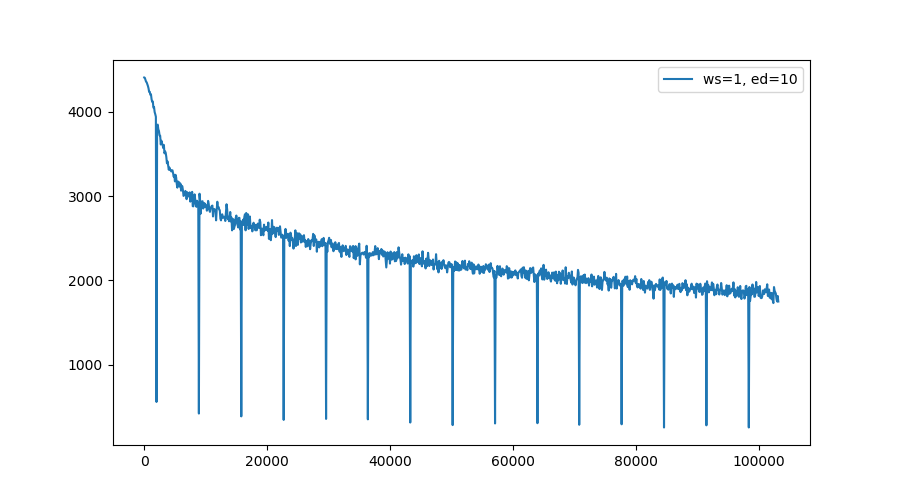

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9., 5.)

fig, ax = plt.subplots()
for trainer_list in lm_trainers:
    for trainer in trainer_list:
        ax.plot(trainer.loss_history['iter'],trainer.loss_history['loss'],
                label='ws={}, ed={}'.format(trainer.window_size, trainer.embedding_dim))
ax.legend()

In [52]:
def GetARPAFile(lm_trainer, test_filename, output_file):
    
    with open(test_filename, 'rb') as testfile:
        test_text = testfile.readlines()
    
    test_corpus = [['<s>'] + re.split(r'[\t \n]',l.decode('iso-8859-1'))[2:-1] + ['</s>'] for l in test_text]
    test_corpus = [token for line in test_corpus for token in line]

    # Probabilidad de los unigramas:
    test_vocab = Vocabulary.from_corpus([test_corpus],cutoff_freq=0)
    train_vocab = lm_trainer.dataloader.dataset.vocabulary
    uniform_prob = max(-99.,-float(np.log(len(train_vocab))))
    unigram_probs = {tk: uniform_prob for tk in test_vocab}
    
    # Probabilidad de los bigramas:
    len_test_corpus = len(test_corpus)
    test_bigrams = sorted(list(set(['{} {}'.format(test_corpus[t-1], test_corpus[t]) for t in range(1,len_test_corpus)])))
    bigram_probs = {}
    for bigram in test_bigrams:
        try:
            w1, w2 = bigram.split(' ')
            idx1, idx2 = train_vocab[w1], train_vocab[w2]
            x = torch.tensor(idx1).to(device=lm_trainer.device)
            bigram_scores = lm_trainer.model(x).squeeze(dim=0)
            bigram_probs[bigram] = min(max(-99.,(bigram_scores - torch.logsumexp(bigram_scores, dim=0))[idx2].item()),0.)
        except KeyError:
            bigram_probs[bigram] = uniform_prob
    
    # Creo el archivo en formato ARPA:
    new_lm_file = ['\n', 
                   '\\data\\\n', 
                   'ngram 1={}\n'.format(len(test_vocab)), 
                   'ngram 2={}\n'.format(len(test_bigrams)), 
                   '\n', 
                   '\\1-grams:\n']
    new_lm_file += ['{:.6f}\t{}\t0\n'.format(p,unigram) for unigram, p in unigram_probs.items()]
    new_lm_file += ['\n'] + ['\\2-grams:\n'] 
    new_lm_file += ['{:.6f}\t{}\n'.format(p,bigram) for bigram, p in bigram_probs.items()]
    new_lm_file += ['\n', '\\end\\\n']

    with open(output_file, 'wb') as file:
        file.write((''.join(new_lm_file)).encode('iso-8859-1'))
    
    return unigram_probs, bigram_probs


test_filename = './promptsl40.test'
output_file = 'lm_bengio'
GetARPAFile(lm_trainers[0][0], test_filename, output_file)

({'</s>': -8.587651655064798,
  '<s>': -8.587651655064798,
  'a': -8.587651655064798,
  'abajo': -8.587651655064798,
  'abandonada': -8.587651655064798,
  'abandonado': -8.587651655064798,
  'abarcan': -8.587651655064798,
  'abastecimiento': -8.587651655064798,
  'abatir': -8.587651655064798,
  'abierta': -8.587651655064798,
  'abiertas': -8.587651655064798,
  'abierto': -8.587651655064798,
  'abra': -8.587651655064798,
  'abrigamos': -8.587651655064798,
  'abril': -8.587651655064798,
  'abrió': -8.587651655064798,
  'abstracto': -8.587651655064798,
  'abundan': -8.587651655064798,
  'aburrida': -8.587651655064798,
  'acaba': -8.587651655064798,
  'acaben': -8.587651655064798,
  'acaso': -8.587651655064798,
  'acatamiento': -8.587651655064798,
  'acceder': -8.587651655064798,
  'acceso': -8.587651655064798,
  'accidente': -8.587651655064798,
  'acciones': -8.587651655064798,
  'acción': -8.587651655064798,
  'acelerar': -8.587651655064798,
  'acento': -8.587651655064798,
  'aceptable':